In [1]:
# import essentials
import os
import shutil

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import keras
from keras.models import Sequential,load_model,model_from_json
from keras import regularizers
from keras.callbacks import EarlyStopping,ModelCheckpoint,ReduceLROnPlateau
from keras.layers import Dense,Conv2D,Activation,Flatten,Dropout
from keras.applications.vgg16 import VGG16
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import SGD,Adam
from keras.utils.vis_utils import plot_model
from keras.utils.np_utils import to_categorical
import keras.backend as K
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score
from PIL import Image
from matplotlib import pyplot
import numpy as np
from keras.models import Model
import matplotlib.pyplot as plt
import csv

# trial series to track our iterations
trial_num = 22
data_change = False # if the split of training and validation is changed

# data info and organizations
img_width,img_height = 224,224
batch_size = 8
epochs = 50
# no / partial / collapse: total 515 {0: 240, 1: 223, 2: 52}
nb_class_train = np.array([200, 180, 36])
nb_class_val = np.array([40, 40, 16])
over_sample_train = np.array([1, 1, 1])
nb_train_samples = np.dot(nb_class_train, over_sample_train.T)
nb_val_samples = np.sum(nb_class_val)
nb_test_samples = 129
num_classes = nb_class_train.shape[0]
channel = 3

# path info
org_X_train_data_dir = './data_org/X_train.npy'
org_Y_train_data_dir = './data_org/Y_train.npy'
train_data_dir = './data_dyna/train'
validation_data_dir = './data_dyna/validation'
test_data_dir = './data_dyna/test'
train_labels_path = './vgg_parameter/train_labels.npy'
val_labels_path = './vgg_parameter/val_labels.npy'
bottleneck_features_train_path = './vgg_parameter/bottleneck_features_train.npy'
bottleneck_features_val_path = './vgg_parameter/bottleneck_features_val.npy'

top_model_weights_path = './vgg_parameter/bottleneck_fc_model' + str(trial_num) + '.h5'
best_model_weights_path = './final_results/best_weights' + str(trial_num) + '.h5'
model_save_path = './final_results/model' + str(trial_num) + '.json'
final_model_weights_path = './final_results/final_weights' + str(trial_num) + '.h5'
learning_hist_path = './final_results/learning_hist' + str(trial_num) + '.csv'
acc_plt_path = './final_results/acc_plt' + str(trial_num) + '.png'
loss_plt_path = './final_results/loss_plt' + str(trial_num) + '.png'
Y_predict_path = './final_results/Y_predict' + str(trial_num) + '.csv'

# set labels    
train_labels = np.array([0]*nb_class_train[0]+[1]*nb_class_train[1]+[2]*nb_class_train[2])
validation_labels = np.array([0]*nb_class_val[0]+[1]*nb_class_val[1]+[2]*nb_class_val[2])


Using TensorFlow backend.


In [2]:
# generate temporary images for Keras' sequence
def process_data():
    
    # load data
    X_train = np.load(org_X_train_data_dir);
    Y_train = np.load(org_Y_train_data_dir);
    
    train_labels = []
    validation_labels = []
    for c in range(num_classes):
        # split data into training and validation, over sampling training data
        index_c = np.where(Y_train == c)[0]
        X_train_c = X_train[index_c[0:nb_class_train[c]],:,:,:]
        X_train_new_c = np.tile(X_train_c,(int(over_sample_train[c]),1,1,1))
        extra_c = int((over_sample_train[c] - int(over_sample_train[c])) * nb_class_train[c])
        X_train_new_c = np.concatenate((X_train_new_c, X_train_c[0:extra_c,:,:,:]))
        Y_train_new_c = np.full((X_train_new_c.shape[0],), c, dtype=int)
        train_labels = np.concatenate((train_labels, Y_train_new_c))
        
        # shuffle and store image (training)
        shuffle_train_c = np.random.choice(X_train_new_c.shape[0], X_train_new_c.shape[0], replace=False)
        for i in range(X_train_new_c.shape[0]):
            im = Image.fromarray(X_train_new_c[shuffle_train_c[i], :, :, :])
            im.save(train_data_dir+'/'+str(c)+'/'+str(c)+'_'+str(i)+'.png')
        
        # split data into training and validation
        X_val_c = X_train[index_c[nb_class_train[c]:nb_class_train[c]+nb_class_val[c]],:,:,:]
        Y_val_new_c = np.full((X_val_c.shape[0],), c, dtype=int)
        validation_labels = np.concatenate((validation_labels, Y_val_new_c))
        
        # shuffle and store image (validation)
        shuffle_val_c = np.random.choice(X_val_c.shape[0], X_val_c.shape[0], replace=False)
        for i in range(X_val_c.shape[0]):
            im = Image.fromarray(X_val_c[shuffle_val_c[i], :, :, :])
            im.save(validation_data_dir+'/'+str(c)+'/'+str(c)+'_'+str(i)+'.png')

    return train_labels, validation_labels

    

In [3]:
# if the data change, re-generate images
if data_change:
    # delete all files and folders in directory
    shutil.rmtree(train_data_dir)
    shutil.rmtree(validation_data_dir)
    # re-make the folders
    os.makedirs(train_data_dir+'/0')
    os.makedirs(train_data_dir+'/1')
    os.makedirs(train_data_dir+'/2')
    os.makedirs(validation_data_dir+'/0')
    os.makedirs(validation_data_dir+'/1')
    os.makedirs(validation_data_dir+'/2')
    # save new images
    train_labels, validation_labels = process_data()
    np.save(open(train_labels_path,'w'), train_labels)
    np.save(open(val_labels_path,'w'), validation_labels)

In [4]:
def save_bottleneck_features():

    datagen = ImageDataGenerator(rescale=1./255, # change here
                                shear_range=0.2,
                                zoom_range=0.2,
                                horizontal_flip=True)

    model = VGG16(include_top=False, weights='imagenet')

    generator_train = datagen.flow_from_directory(train_data_dir,
                                        target_size=(img_width,img_height),
                                        batch_size=batch_size,
                                        class_mode=None,
                                        shuffle=False)
    bottleneck_features_train = model.predict_generator(generator_train,nb_train_samples//batch_size)
    np.save(open(bottleneck_features_train_path,'w'),bottleneck_features_train)

    generator_val = datagen.flow_from_directory(validation_data_dir,
                                            target_size=(img_width,img_height),
                                            batch_size=batch_size,
                                            class_mode=None,
                                            shuffle=False)
    bottleneck_features_validation = model.predict_generator(generator_val,
                                                             nb_val_samples//batch_size)
    # save file ,format: .npy
    np.save(open(bottleneck_features_val_path,'w'),bottleneck_features_validation)
    
#     # check the order of how the 'flow_from_directory' function in keras takes the images
#     print(generator_train.filenames)
#     print(generator_train.class_indices)
#     print(generator_train.classes.shape)
    

In [5]:
# train the FC layer

def train_top_model():
    
    # get the class lebels for the training data, in the original order
#     train_labels = np.array([0]*nb_class_train[0]+[1]*nb_class_train[1]+[2]*nb_class_train[2])
#     validation_labels = np.array([0]*nb_class_val[0]+[1]*nb_class_val[1]+[2]*nb_class_val[2])
    train_labels = np.load(train_labels_path)
    train_labels = to_categorical(train_labels, num_classes=num_classes)
    validation_labels = np.load(val_labels_path)
    validation_labels = to_categorical(validation_labels, num_classes=num_classes)
#     print(train_labels.shape)
#     print(train_labels)
#     print(validation_labels.shape)

    
    train_data = np.load(open(bottleneck_features_train_path))
    print 'train_data shape',train_data.shape
    

    validation_data = np.load(open(bottleneck_features_val_path))
    print 'validation_data',validation_data.shape
    
    model = Sequential()
    model.add(Flatten(input_shape=train_data.shape[1:]))
    model.add(Dense(256,activation='relu'))
    model.add(Dropout(0.7))
    model.add(Dense(num_classes,activation='softmax'))
    
    print model.summary()

    model.compile(optimizer='rmsprop',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    model.fit(train_data,train_labels,
              epochs=epochs, # change here
              batch_size=batch_size,
              validation_data=(validation_data,validation_labels))
    model.save_weights(top_model_weights_path)



In [6]:
# if bottleneck info is not created, then run to store
is_run_bottleneck = os.path.isfile(bottleneck_features_train_path)
if (not is_run_bottleneck) or (data_change):
    save_bottleneck_features()

# train the FC layer
train_top_model()


train_data shape (416, 7, 7, 512)
validation_data (96, 7, 7, 512)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               6422784   
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 771       
Total params: 6,423,555
Trainable params: 6,423,555
Non-trainable params: 0
_________________________________________________________________
None
Train on 416 samples, validate on 96 samples
Epoch 1/50
416/416 [==============================] - 1s 4ms/step - loss: 6.7105 - acc: 0.4760 - val_loss: 8.3986 - val_acc: 0.4167
Epoch 2/50
416/4

In [7]:
input_shape = (img_width,img_height,channel)
model = VGG16(include_top=False, weights='imagenet', input_shape=input_shape)
x = model.output

# add FC layers to the conv2D
x = Flatten(name='flatten')(x)
print(x.shape)
# x = Dense(256,activation='relu',kernel_regularizer=regularizers.l2(0.1))(x) #change L2
x = Dense(256,activation='relu')(x)
x = Dropout(0.7)(x) # #change dropout
predictions = Dense(num_classes,activation='softmax')(x)
vgg_model = Model(model.input,predictions)
vgg_model.load_weights(top_model_weights_path,by_name=True)
# print len(vgg_model.layers) # 23

dict_layers = dict([(layer.name,layer) for layer in vgg_model.layers])
# print len(dict_layers) # 23
# plot_model(vgg_model,to_file='vgg16_fc.png',show_shapes=True)

# freezing layers of VGG-16
for layer in vgg_model.layers[1:14]: # change here
    # print layer.name,layer
    layer.trainable = False

(?, ?)


In [8]:
# compute F1 score as a custom metric to return
def F1(y_true, y_pred):
    def recall(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [9]:
# train with low learning rate

sgd = SGD(lr=1e-4,momentum=0.9) # change learning rate
vgg_model.compile(loss='categorical_crossentropy',
                  optimizer=sgd,
                  metrics=['accuracy', F1])

# adam = Adam(lr=1e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-8, decay=0.0, amsgrad=False)
# vgg_model.compile(loss='binary_crossentropy',
#                   optimizer=adam,
#                   metrics=['accuracy'])


# train vgg_model
train_datagen = ImageDataGenerator(rescale=1./255, # change data augmentation
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True)
val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(train_data_dir,
                                                    target_size=(img_width,img_height),
                                                    batch_size=batch_size,
                                                    class_mode='categorical')
validation_generator = val_datagen.flow_from_directory(validation_data_dir,
                                                       target_size=(img_width,img_height),
                                                       batch_size=batch_size,
                                                       class_mode='categorical')

# print(train_generator.filenames)
# print(train_generator.class_indices)
# print(train_generator.classes)

# train

# early_stop = EarlyStopping(monitor='val_acc', patience=10, verbose=0, mode='auto')
mcp_save = ModelCheckpoint(best_model_weights_path, save_best_only=True, monitor='val_F1', verbose=1, mode='max')
# mcp_save = ModelCheckpoint(best_model_weights_path, save_best_only=True, monitor='val_acc', verbose=1, mode='auto')
reduce_lr_loss = ReduceLROnPlateau(monitor='val_F1', factor=0.5, patience=5, min_lr=1e-7, verbose=1, mode='max') # change factor, patience and min_lr

history = vgg_model.fit_generator(train_generator,
                                  steps_per_epoch=nb_train_samples // batch_size,
                                  epochs=30, # change here
                                  validation_data=validation_generator,
                                  validation_steps=nb_val_samples // batch_size,
                                  verbose=2,
                                  callbacks = [mcp_save,reduce_lr_loss])



Found 416 images belonging to 3 classes.
Found 96 images belonging to 3 classes.
Epoch 1/30
 - 6s - loss: 1.1625 - acc: 0.4760 - F1: 0.4408 - val_loss: 0.9821 - val_acc: 0.5625 - val_F1: 0.2013

Epoch 00001: val_F1 improved from -inf to 0.20126, saving model to ./final_results/best_weights22.h5
Epoch 2/30
 - 5s - loss: 0.9371 - acc: 0.5192 - F1: 0.4462 - val_loss: 0.9880 - val_acc: 0.5104 - val_F1: 0.4775

Epoch 00002: val_F1 improved from 0.20126 to 0.47755, saving model to ./final_results/best_weights22.h5
Epoch 3/30
 - 5s - loss: 0.8840 - acc: 0.5865 - F1: 0.4959 - val_loss: 0.9250 - val_acc: 0.6146 - val_F1: 0.5389

Epoch 00003: val_F1 improved from 0.47755 to 0.53886, saving model to ./final_results/best_weights22.h5
Epoch 4/30
 - 5s - loss: 0.8322 - acc: 0.5986 - F1: 0.5431 - val_loss: 0.8935 - val_acc: 0.6042 - val_F1: 0.5549

Epoch 00004: val_F1 improved from 0.53886 to 0.55485, saving model to ./final_results/best_weights22.h5
Epoch 5/30
 - 5s - loss: 0.8463 - acc: 0.6034 - F1

In [10]:
# save model for reference
model_json = vgg_model.to_json()
with open(model_save_path, "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
vgg_model.save_weights(final_model_weights_path)
print("Saved model to disk")


Saved model to disk


['acc', 'loss', 'F1', 'lr', 'val_F1', 'val_acc', 'val_loss']


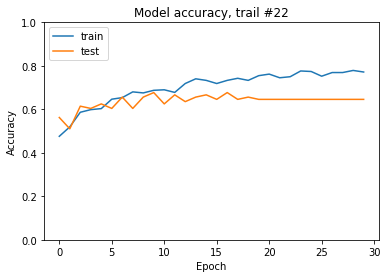

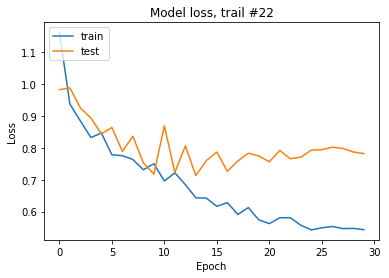

In [11]:
# save learning history info to csv
hist_info = history.history
with open(learning_hist_path, 'wb') as csv_file:
    writer = csv.writer(csv_file)
    for key, value in hist_info.items():
       writer.writerow([key, value])

# plot summary of learning
# list all data in history
print(history.history.keys())
# summarize history for accuracy
fig1 = plt.gcf()
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy, trail #' + str(trial_num))
plt.ylim(0, 1)
# plt.xlim(0, 100)
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
fig1.savefig(acc_plt_path, bbox_inches='tight')
# summarize history for loss
fig2 = plt.gcf()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss, trail #' + str(trial_num))
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
fig2.savefig(loss_plt_path, bbox_inches='tight')

In [12]:
# given X_test, predict Y (use the model stored with smallest val_loss)

# load model
# load json and create model
json_file = open(model_save_path, 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights(best_model_weights_path)
print("Loaded model from disk")

test_datagen = ImageDataGenerator(rescale=1./255)
generator_test = test_datagen.flow_from_directory(test_data_dir,
                                        target_size=(img_width,img_height),
                                        batch_size=1,
                                        class_mode=None,
                                        shuffle=False)
A = loaded_model.predict_generator(generator_test,nb_test_samples)
# print(A.shape)
# print(A)

Loaded model from disk
Found 129 images belonging to 1 classes.


In [13]:
# generate Y predict
# Y_predict = np.zeros((A.shape[0],1))
# for i in range(A.shape[0]):
#     if A[i,0] > 0.5:
#         Y_predict[i,0] = 1
Y_predict = A.argmax(axis=1)
Y_predict = Y_predict[:,np.newaxis]
# print(Y_predict)
print(Y_predict.shape)

(129, 1)


In [14]:
# save prediction as Kaggle format
index = np.arange(0, nb_test_samples)
# print(index[:, np.newaxis].shape)
# print(index[:, np.newaxis])
out = np.concatenate((index[:, np.newaxis], Y_predict), axis = 1)
with open(Y_predict_path, "wb") as f:
    f.write(b'Index,Pred\n')
    np.savetxt(f, out.astype(int), fmt='%i', delimiter=",")

In [15]:
print vgg_model.summary()
print vgg_model.layers
# plot_model(vgg_model, to_file='model.png')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________